In [33]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

In [74]:
X_train = np.array([[1.149, 0.959], [1.194, 1.457], [0.930, 0.930], [1.474, 1.230], [0.859, 1.163],
 [0.861, 0.860], [1.073, 0.426], [0.483, 0.831], [0.696, 1.094], [0.728, 0.576],
 [1.440, 0.932], [1.020, 0.573], [0.837, 1.033], [0.655, 1.113], [0.820, 0.912],
 [2.319, 3.056], [2.496, 2.183], [2.747, 2.134], [2.563, 1.912], [2.102, 2.559],
 [2.722, 2.551], [2.465, 2.410], [2.056, 2.284], [2.362, 2.817], [2.603, 1.971],
 [2.597, 2.384], [2.297, 2.684], [2.809, 2.779], [2.248, 2.407], [2.599, 2.793]])

y_train = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
)


<Axes: >

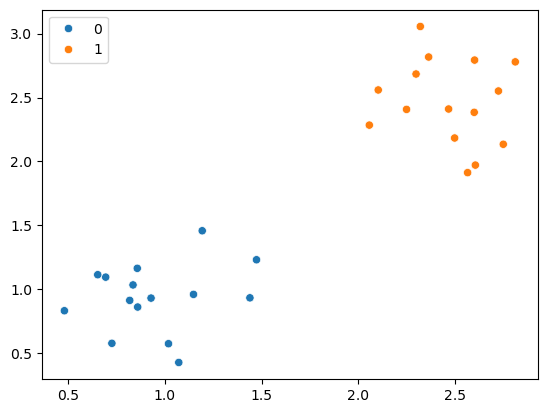

In [3]:
sns.scatterplot(x = X_train[:, 0], y = X_train[:, 1], hue=y_train)

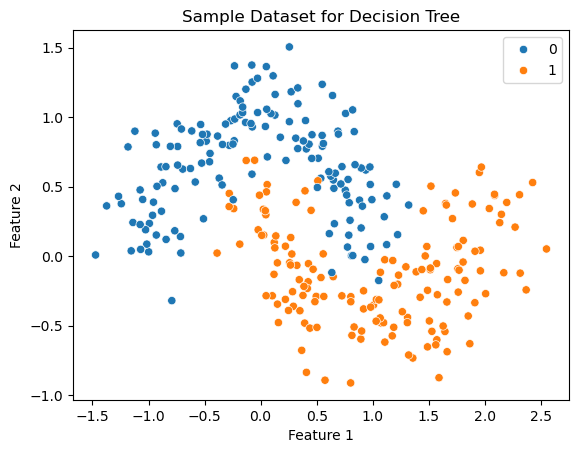

In [4]:
X, y = make_moons(n_samples=300, noise=0.2, random_state=42)

# 시각화
sns.scatterplot(x = X[:, 0], y = X[:, 1], hue= y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Sample Dataset for Decision Tree")
plt.show()


In [5]:
df = pd.read_csv("iris.csv")
df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In [6]:
class Node():
    def __init__(self, feature_index = None, threshold = None, left = None, right = None, info_gain = None, value = None):

        ## decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
    
        ## leaf node
        self.value = value

In [50]:
class DecisionTreeClassifier():
    def __init__(self, min_sample_split = 2, max_depth = 2, criterion="entropy"):

        ## root initalize
        self.root = None

        ## criterion
        self.criterion = criterion

        ## set stopping condition
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split

    def build_tree(self, dataset, current_depth = 0):
        """recursive function to bulid tree"""

        X, y = dataset[:,:-1], dataset[:, -1]

        ## number of samples and features
        num_samples, num_features = np.shape(X)

        ## repeat until stopping conditoins are met
        if current_depth <= self.max_depth and num_samples >= self.min_sample_split and len(np.unique(y)) >= 2: 
            ## find the split
            split = self.get_split(dataset, num_features)

            if split["info_gain"] > 0 :
                ## make_left_tree / recursive
                left_subtree = self.build_tree(split["dataset_left"], current_depth + 1)
                ## make_right_tree / recursive
                right_subtree = self.build_tree(split["dataset_right"], current_depth + 1)

            ## return Node
            node = Node(feature_index = split["feature_index"], threshold = split["threshold"],
                        left = left_subtree, right = right_subtree, info_gain = split["info_gain"])
            return node

        ## make leaf
        leaf_value = self.calculate_leaf_value(y)
        return Node(value = leaf_value)


    def get_split(self, dataset, num_features):
        """function to find split"""

        ## store split data
        split = {}
        max_info_gain = -10e7

        ## loop overall features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            thresholds = self.get_thresholds(feature_values)

            ## loop overall possible thresholds
            for threshold in thresholds:
                ## get split by current threshold
                dataset_left, dataset_right = self.split(dataset, feature_index ,threshold)
                ## calculate information gain
                y, y_left, y_right = dataset[:,-1], dataset_left[:,-1], dataset_right[:,-1]
                curr_info_gain = self.information_gain(y, y_left, y_right, self.criterion)
                ## find best split
                if curr_info_gain > max_info_gain:
                    split["feature_index"] = feature_index
                    split["threshold"] = threshold
                    split["dataset_left"] = dataset_left
                    split["dataset_right"] = dataset_right
                    split["info_gain"] = curr_info_gain
                    max_info_gain = curr_info_gain

        ## return best split
        return split

    def get_thresholds(self, feature_values):
        """function to get theresholds"""

        ## unique_values
        unique_values = np.sort(np.unique(feature_values))
        n = len(unique_values)

        ## calculate medians of values
        tmp = np.insert(unique_values, 0,0) + np.insert(unique_values, n,0)
        thresholds = np.delete(tmp/2,[0,n])

        return thresholds

    
    def split(self, dataset, feature_index, threshold):
        """function to split data by threshlod"""

        dataset_left  = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])               

        return dataset_left, dataset_right
    
    def information_gain(self, y, y_left, y_right, criterion):
        """compute information gain"""

        ## weight
        weight_left = len(y_left) / len(y)
        weight_right = len(y_right) / len(y)

        ## compute info_gain by criterion
        if criterion == "entropy":
            gain = self.entropy(y) - (weight_left * self.entropy(y_left) + weight_right * self.entropy(y_right))
        elif criterion == "gini":
           gain = self.gini(y) - (weight_left * self.gini(y_left) + weight_right * self.gini(y_right))
        
        return gain
    
    def entropy(self, y):
        """function to compute entorpy"""

        entropy = 0
        ## for multi class
        unique_class = np.unique(y) 
        for cls in unique_class:
            p = len(y[y==cls])/len(y)
            if p == 0:
                entropy += 0
            else :
                entropy += -p * np.log2(p)
        return entropy
    
    def gini(self, y):
        """function to compute gini index"""
        ##  not yet
        pass
        
    def calculate_leaf_value(self, y):
        """function to compute mode value"""
        y = list(y)
        return max(y, key=y.count)
    
    def fit(self, X, y):
        """funtion to train the tree"""

        dataset = np.c_[X,y]
        self.root = self.build_tree(dataset=dataset)
    
    def predict(self, X):
        """function to predict data"""

        prediction = [self.prediction(x, self.root) for x in X]
        return prediction
    
    def prediction(self, x, tree):

        if tree.value != None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.prediction(x, tree.left)
        else:
            return self.prediction(x, tree.right)


In [61]:
from sklearn.model_selection import train_test_split

X_tr, X_cv, y_tr, y_cv = train_test_split(X, y)
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_tr, y_tr)
model

In [62]:
cv_pred = model.predict(X_cv)
tr_pred = model.predict(X_tr)
print(accuracy_score(y_cv, cv_pred))
print(accuracy_score(y_tr, tr_pred))

0.92
0.9911111111111112


In [64]:
npiris = np.array(df)
iris_X, iris_y = npiris[:,:-1], npiris[:,-1]

In [85]:
X_train, X_test, y_train, y_test = train_test_split(iris_X, iris_y)

model2 = DecisionTreeClassifier(max_depth=3)
model2.fit(X_train, y_train)
model2

In [86]:
test_pred = model2.predict(X_test)
train_pred = model2.predict(X_train)

print(f"Train Accuracy      : {accuracy_score(y_train, train_pred)}")
print(f"Validation Accuracy : {accuracy_score(y_test, test_pred)}")

Train Accuracy      : 0.9910714285714286
Validation Accuracy : 0.9473684210526315
